In [52]:
import os

import h5py
import himalaya.scoring
from datalad.interface.results import results_from_annex_noinfo
from himalaya.scoring import r2_score
import numpy as np
import pandas as pd
from himalaya.backend import set_backend
from himalaya.ridge import ColumnTransformerNoStack, BandedRidgeCV, RidgeCV
from matplotlib import pyplot as plt
import seaborn as sns
import simplstyles
from scipy.stats import zscore
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import make_pipeline
from voxelwise_tutorials.delayer import Delayer
from voxelwise_tutorials.io import load_hdf5_array

In [12]:
backend = set_backend("torch_cuda", on_error='throw')
plt.style.use('nord-light-talk')
os.environ["SCIPY_ARRAY_API"] = "1"
data_dir = "../../data"
subject = 1
modality = "reading"
trim = 5
number_of_delays = 4
n_targets_batch = 100
n_targets_batch_refit = 50

In [13]:
alphas = np.logspace(-5, 5, 10)
n_iter = 25
cv = 5

# Load features

In [14]:
features_train = h5py.File(os.path.join(data_dir, 'features', 'features_trn_NEW.hdf'), 'r')
features_val = h5py.File(os.path.join(data_dir, 'features', 'features_val_NEW.hdf'), 'r')

In [22]:
semantic_train = np.vstack([zscore(features_train[story]['english1000']) for story in features_train.keys()])
semantic_val = np.vstack([zscore(features_val[story]['english1000']) for story in features_val.keys()])

semantic_train = semantic_train.astype(np.float32)
semantic_val = semantic_val.astype(np.float32)
print(semantic_train.shape, semantic_val.shape)

(3887, 985) (306, 985)


# Load brain data

In [21]:
Y_train_filename = os.path.join(data_dir, 'responses', f'subject{subject:02}_{modality}_fmri_data_trn.hdf')
Y_train = load_hdf5_array(Y_train_filename)

Y_test_filename = os.path.join(data_dir, 'responses', f'subject{subject:02}_{modality}_fmri_data_val.hdf')
Y_test = load_hdf5_array(Y_test_filename)

Y_train = np.vstack([zscore(Y_train[story][:-trim]) for story in Y_train.keys()])
Ys_test = [np.vstack([zscore(Y_test[story][i][:-trim]) for story in Y_test.keys()]) for i in range(2)]

Y_train, Ys_test = np.nan_to_num(Y_train), np.nan_to_num(Ys_test)
Y_train = Y_train.astype(np.float32)
Ys_test = [Y_test.astype(np.float32) for Y_test in Ys_test]
print(Y_train.shape, Ys_test[0].shape, Ys_test[1].shape)

/tmp/ipykernel_38448/335795169.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Y_train = np.vstack([zscore(Y_train[story][:-trim]) for story in Y_train.keys()])
/tmp/ipykernel_38448/335795169.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Y_train = np.vstack([zscore(Y_train[story][:-trim]) for story in Y_train.keys()])
/tmp/ipykernel_38448/335795169.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Y_train = np.vstack([zscore(Y_train[story][:-trim]) for story in Y_train.keys()])
/tmp/ipykernel_38448/335795169.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cance

(3887, 81133) (306, 81133) (306, 81133)


# Plot validation curves

In [17]:
class BandedEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, alphas=alphas, n_iter=n_iter, cv=cv, n_targets_batch=n_targets_batch,
                 n_targets_batch_refit=n_targets_batch_refit, score_func=r2_score, number_of_delays=number_of_delays):
        self.alphas = alphas
        self.n_iter = n_iter
        self.cv = cv
        self.n_targets_batch = n_targets_batch
        self.n_targets_batch_refit = n_targets_batch_refit
        self.score_func = score_func
        self.number_of_delays = number_of_delays

    def fit(self, X, y):
        delayer = Delayer(delays=range(1, self.number_of_delays + 1))

        start_and_end = [0, X.shape[1]]
        slices = [
            slice(start, end)
            for start, end in zip(start_and_end[:-1], start_and_end[1:])
        ]
        ct = ColumnTransformerNoStack(transformers=[(f'feature_{i}', delayer, s) for i, s in enumerate(slices)])
        print(ct)

        solver_params = dict(
            alphas=self.alphas,
            n_iter=self.n_iter,
            n_targets_batch=self.n_targets_batch,
            n_targets_batch_refit=self.n_targets_batch_refit,
            score_func=self.score_func
        )
        banded_ridge_cv = BandedRidgeCV(cv=self.cv, groups="input", solver_params=solver_params)

        self.pipeline = make_pipeline(
            ct,
            banded_ridge_cv
        )
        self.pipeline.fit(X, y)
        return self

    def predict(self, X):
        return self.pipeline.predict(X)

In [18]:
class RidgeEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, alphas=alphas, cv=cv, n_targets_batch=n_targets_batch,
                 n_targets_batch_refit=n_targets_batch_refit, score_func=r2_score, number_of_delays=number_of_delays):
        self.alphas = alphas
        self.cv = cv
        self.n_targets_batch = n_targets_batch
        self.n_targets_batch_refit = n_targets_batch_refit
        self.score_func = score_func
        self.number_of_delays = number_of_delays

    def fit(self, X, y):
        delayer = Delayer(delays=range(1, self.number_of_delays + 1))

        solver_params = dict(
            n_targets_batch=self.n_targets_batch,
            n_targets_batch_refit=self.n_targets_batch_refit,
            score_func=self.score_func
        )
        ridge_cv = RidgeCV(alphas=self.alphas, cv=self.cv, solver_params=solver_params)

        self.pipeline = make_pipeline(
            delayer,
            ridge_cv
        )
        self.pipeline.fit(X, y)
        return self

    def predict(self, X):
        return self.pipeline.predict(X)

In [19]:
def result_path(subject, modality, ridge_type, param_name, param_range):
    dir = f"results/brain_maps_validation_curves/{modality}/{subject}/{ridge_type}"
    os.makedirs(dir, exist_ok=True)
    path = os.path.join(dir, f"{param_name}_{param_range}.csv")
    return path

In [49]:
param_range = np.logspace(-5, 15, 11)
param_range

array([1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05, 1.e+07, 1.e+09,
       1.e+11, 1.e+13, 1.e+15])

In [54]:
delayer = Delayer(delays=range(1, number_of_delays + 1))

solver_params = dict(
    n_targets_batch=n_targets_batch,
    n_targets_batch_refit=n_targets_batch_refit,
    score_func=himalaya.scoring.r2_score
)
ridge_cv = RidgeCV(alphas=param_range, cv=cv, solver_params=solver_params)
pipeline = make_pipeline(
    delayer,
    ridge_cv
)
pipeline

Pipeline(steps=[('delayer', Delayer(delays=range(1, 5))),
                ('ridgecv',
                 RidgeCV(alphas=array([1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05, 1.e+07, 1.e+09,
       1.e+11, 1.e+13, 1.e+15]),
                         solver_params={'n_targets_batch': 100,
                                        'n_targets_batch_refit': 50,
                                        'score_func': <function r2_score at 0x777cbcc5c7c0>}))])

In [ ]:
pipeline.fit(semantic_train, Y_train)
pipeline

/home/leo/PycharmProjects/BlenderVesicles/.venv/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/leo/PycharmProjects/BlenderVesicles/.venv/lib/python3.13/site-packages/himalaya/ridge/_random_search.py:491: UserWarning: Solving ridge is slower than solving kernel ridge when n_samples < n_features (here 3887 < 3940). Using a linear kernel in himalaya.kernel_ridge.KernelRidgeCV or himalaya.kernel_ridge.solve_kernel_ridge_cv_eigenvalues would be faster. Use warn=False to silence this warning.
  warnings.warn(


In [50]:
r2_scores = []
for alpha in param_range:
    print(alpha)
    path = result_path(subject, modality, "RidgeCV", param_name, alpha)
    if not os.path.exists(path):
        print(f"Computing {path}")
        r2 = pd.DataFrame()
        estimator = RidgeEstimator(alphas=[alpha])
        estimator.fit(semantic_train, Y_train)
        prediction = estimator.predict(semantic_val)
        score_0 = r2_score(Ys_test[0], prediction)
        score_1 = r2_score(Ys_test[1], prediction)
        score_0 = backend.to_numpy(score_0)
        score_1 = backend.to_numpy(score_1)
        # 81133 is the number of voxels
        r2 = pd.concat([r2, pd.DataFrame({
            'score_0': score_0,
            'score_1': score_1,
        }, index=list(range(len(score_0))))])
        r2.to_csv(path)
        r2_scores.append(r2)
    else:
        print(f"Loading {path}")
        r2 = pd.read_csv(path, index_col=0)
        r2_scores.append(r2)

1e-05
Computing results/brain_maps_validation_curves/reading/1/RidgeCV/alphas_1e-05.csv


/home/leo/PycharmProjects/BlenderVesicles/.venv/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/leo/PycharmProjects/BlenderVesicles/.venv/lib/python3.13/site-packages/himalaya/ridge/_random_search.py:491: UserWarning: Solving ridge is slower than solving kernel ridge when n_samples < n_features (here 3887 < 3940). Using a linear kernel in himalaya.kernel_ridge.KernelRidgeCV or himalaya.kernel_ridge.solve_kernel_ridge_cv_eigenvalues would be faster. Use warn=False to silence this warning.
  warnings.warn(


0.001
Computing results/brain_maps_validation_curves/reading/1/RidgeCV/alphas_0.001.csv


/home/leo/PycharmProjects/BlenderVesicles/.venv/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/leo/PycharmProjects/BlenderVesicles/.venv/lib/python3.13/site-packages/himalaya/ridge/_random_search.py:491: UserWarning: Solving ridge is slower than solving kernel ridge when n_samples < n_features (here 3887 < 3940). Using a linear kernel in himalaya.kernel_ridge.KernelRidgeCV or himalaya.kernel_ridge.solve_kernel_ridge_cv_eigenvalues would be faster. Use warn=False to silence this warning.
  warnings.warn(


0.1
Loading results/brain_maps_validation_curves/reading/1/RidgeCV/alphas_0.1.csv
10.0
Computing results/brain_maps_validation_curves/reading/1/RidgeCV/alphas_10.0.csv


/home/leo/PycharmProjects/BlenderVesicles/.venv/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/leo/PycharmProjects/BlenderVesicles/.venv/lib/python3.13/site-packages/himalaya/ridge/_random_search.py:491: UserWarning: Solving ridge is slower than solving kernel ridge when n_samples < n_features (here 3887 < 3940). Using a linear kernel in himalaya.kernel_ridge.KernelRidgeCV or himalaya.kernel_ridge.solve_kernel_ridge_cv_eigenvalues would be faster. Use warn=False to silence this warning.
  warnings.warn(


1000.0
Computing results/brain_maps_validation_curves/reading/1/RidgeCV/alphas_1000.0.csv


/home/leo/PycharmProjects/BlenderVesicles/.venv/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/leo/PycharmProjects/BlenderVesicles/.venv/lib/python3.13/site-packages/himalaya/ridge/_random_search.py:491: UserWarning: Solving ridge is slower than solving kernel ridge when n_samples < n_features (here 3887 < 3940). Using a linear kernel in himalaya.kernel_ridge.KernelRidgeCV or himalaya.kernel_ridge.solve_kernel_ridge_cv_eigenvalues would be faster. Use warn=False to silence this warning.
  warnings.warn(


100000.0
Loading results/brain_maps_validation_curves/reading/1/RidgeCV/alphas_100000.0.csv
10000000.0
Computing results/brain_maps_validation_curves/reading/1/RidgeCV/alphas_10000000.0.csv


/home/leo/PycharmProjects/BlenderVesicles/.venv/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/leo/PycharmProjects/BlenderVesicles/.venv/lib/python3.13/site-packages/himalaya/ridge/_random_search.py:491: UserWarning: Solving ridge is slower than solving kernel ridge when n_samples < n_features (here 3887 < 3940). Using a linear kernel in himalaya.kernel_ridge.KernelRidgeCV or himalaya.kernel_ridge.solve_kernel_ridge_cv_eigenvalues would be faster. Use warn=False to silence this warning.
  warnings.warn(


1000000000.0
Computing results/brain_maps_validation_curves/reading/1/RidgeCV/alphas_1000000000.0.csv


/home/leo/PycharmProjects/BlenderVesicles/.venv/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/leo/PycharmProjects/BlenderVesicles/.venv/lib/python3.13/site-packages/himalaya/ridge/_random_search.py:491: UserWarning: Solving ridge is slower than solving kernel ridge when n_samples < n_features (here 3887 < 3940). Using a linear kernel in himalaya.kernel_ridge.KernelRidgeCV or himalaya.kernel_ridge.solve_kernel_ridge_cv_eigenvalues would be faster. Use warn=False to silence this warning.
  warnings.warn(


100000000000.0
Loading results/brain_maps_validation_curves/reading/1/RidgeCV/alphas_100000000000.0.csv
10000000000000.0
Computing results/brain_maps_validation_curves/reading/1/RidgeCV/alphas_10000000000000.0.csv


/home/leo/PycharmProjects/BlenderVesicles/.venv/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/leo/PycharmProjects/BlenderVesicles/.venv/lib/python3.13/site-packages/himalaya/ridge/_random_search.py:491: UserWarning: Solving ridge is slower than solving kernel ridge when n_samples < n_features (here 3887 < 3940). Using a linear kernel in himalaya.kernel_ridge.KernelRidgeCV or himalaya.kernel_ridge.solve_kernel_ridge_cv_eigenvalues would be faster. Use warn=False to silence this warning.
  warnings.warn(


1000000000000000.0
Computing results/brain_maps_validation_curves/reading/1/RidgeCV/alphas_1000000000000000.0.csv


/home/leo/PycharmProjects/BlenderVesicles/.venv/lib/python3.13/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/leo/PycharmProjects/BlenderVesicles/.venv/lib/python3.13/site-packages/himalaya/ridge/_random_search.py:491: UserWarning: Solving ridge is slower than solving kernel ridge when n_samples < n_features (here 3887 < 3940). Using a linear kernel in himalaya.kernel_ridge.KernelRidgeCV or himalaya.kernel_ridge.solve_kernel_ridge_cv_eigenvalues would be faster. Use warn=False to silence this warning.
  warnings.warn(


## find voxels, which improved over the range of alphas

In [36]:
total_r2_scores = pd.DataFrame()
# hstack r2_scores
for alpha, r2 in zip(param_range, r2_scores):
    total_r2_scores[alpha] = r2['score_0']
total_r2_scores.head()

,1.000000e-10,1.000000e-07,1.000000e-04,1.000000e-01,1.000000e+02,1.000000e+05,1.000000e+08,1.000000e+11,1.000000e+14,1.000000e+17,1.000000e+20
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
improvements = total_r2_scores.diff(axis=1).iloc[:, 1:]
# count number of improvements
improvements = improvements > 0
improvements.head()

,1.000000e-07,1.000000e-04,1.000000e-01,1.000000e+02,1.000000e+05,1.000000e+08,1.000000e+11,1.000000e+14,1.000000e+17,1.000000e+20
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
81128,True,True,True,True,True,True,True,False,False,False
81129,True,True,True,True,True,False,False,False,False,False
81130,False,False,False,False,False,False,False,False,False,False
81131,False,False,False,False,False,False,False,False,False,False


([<matplotlib.axis.XTick at 0x777ced85ec10>,
 [Text(0, 0, '1.00e-10'),
  Text(1, 0, '1.00e-07'),
  Text(2, 0, '1.00e-04'),
  Text(3, 0, '1.00e-01'),
  Text(4, 0, '1.00e+02'),
  Text(5, 0, '1.00e+05'),
  Text(6, 0, '1.00e+08'),
  Text(7, 0, '1.00e+11'),
  Text(8, 0, '1.00e+14'),
  Text(9, 0, '1.00e+17'),
  Text(10, 0, '1.00e+20')])

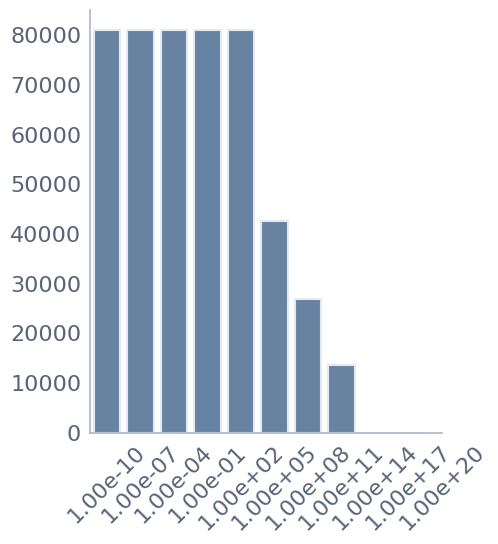

In [44]:
sns.catplot(improvements.sum(), kind='bar')
plt.xticks(np.arange(len(param_range)), labels=[f"{param:.2e}" for param in param_range],rotation=45)

In [46]:
# reverse r2 scores columns
reverse_r2_scores = total_r2_scores.iloc[:, ::-1]
improvements = reverse_r2_scores.diff(axis=1).iloc[:, 1:]
improvements = improvements > 0
improvements.head()

,1.000000e+17,1.000000e+14,1.000000e+11,1.000000e+08,1.000000e+05,1.000000e+02,1.000000e-01,1.000000e-04,1.000000e-07,1.000000e-10
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False


([<matplotlib.axis.XTick at 0x777be240dbd0>,
 [Text(0, 0, '1.00e-10'),
  Text(1, 0, '1.00e-07'),
  Text(2, 0, '1.00e-04'),
  Text(3, 0, '1.00e-01'),
  Text(4, 0, '1.00e+02'),
  Text(5, 0, '1.00e+05'),
  Text(6, 0, '1.00e+08'),
  Text(7, 0, '1.00e+11'),
  Text(8, 0, '1.00e+14'),
  Text(9, 0, '1.00e+17'),
  Text(10, 0, '1.00e+20')])

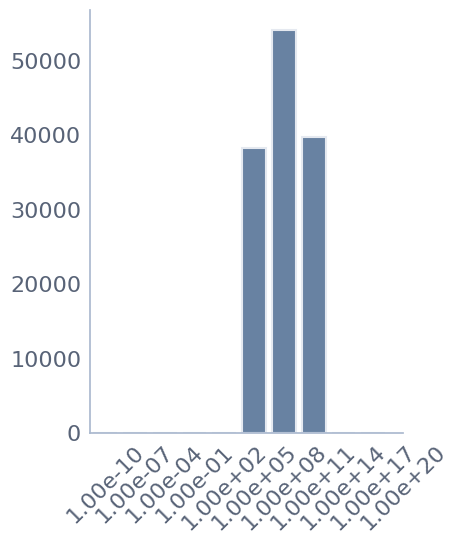

In [48]:
sns.catplot(improvements.sum(), kind='bar')
plt.xticks(np.arange(len(param_range)), labels=[f"{param:.2e}" for param in param_range],rotation=45)